# Run Circuits with Noise

In [36]:
from qibo import gates
from qibo.cskim_utils.gen_circuit import random_control_circuit_qibo
from qibo.models.qft import QFT

from matplotlib import pyplot as plt
from qibo.cskim_utils.connectivity import complete_connectivity_nx, cycle_connectivity_nx, line_connectivity_nx, star_connectivity
import networkx as nx
import numpy as np

from qibo.cskim_utils.gen_circuit import gen_transpiled_circuits_qibo
from qibo.noise import NoiseModel, PauliError
from qibo.transpiler.placer import ReverseTraversal
from qibo.transpiler.router import Sabre


In [37]:
# Circuits to test: QFT(5) and random CZ circuit

nqubits = 5
qft_circ = QFT(nqubits)
qft_circ.add(gates.M(0, 1, 2, 3, 4))
print("QFT(5) circuit")
print(qft_circ.draw(line_wrap=1000))

random_cz_circ = random_control_circuit_qibo(nqubits, 5)
random_cz_circ.add(gates.M(0, 1, 2, 3, 4))
print("\nRandom CZ circuit")
print(random_cz_circ.draw(line_wrap=1000))

QFT(5) circuit
q0: ─H─U1─U1─U1─U1───────────────────────────x───M─
q1: ───o──|──|──|──H─U1─U1─U1────────────────|─x─M─
q2: ──────o──|──|────o──|──|──H─U1─U1────────|─|─M─
q3: ─────────o──|───────o──|────o──|──H─U1───|─x─M─
q4: ────────────o──────────o───────o────o──H─x───M─

Random CZ circuit
q0: ─────o─Z───M─
q1: ─────|─o───M─
q2: ───o─|───Z─M─
q3: ─Z─|─Z───o─M─
q4: ─o─Z───────M─


Star Connectivity


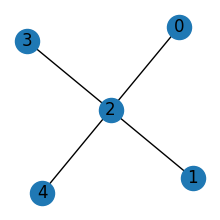

Cycle Connectivity


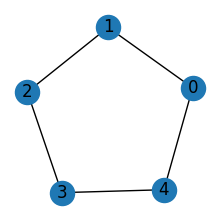

Complete Connectivity


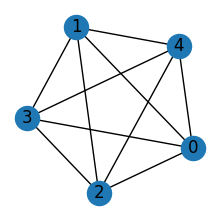

Line Connectivity


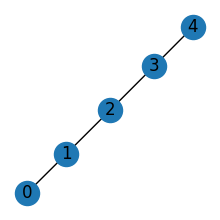

In [38]:
# Connectivity check

conn_star = star_connectivity()
conn_cycle = cycle_connectivity_nx(nqubits)
conn_complete = complete_connectivity_nx(nqubits)
conn_line = line_connectivity_nx(nqubits)

print("Star Connectivity")
plt.figure(figsize=(2, 2)) 
nx.draw(conn_star, with_labels=True)
plt.show()
print("Cycle Connectivity")
plt.figure(figsize=(2, 2)) 
nx.draw(conn_cycle, with_labels=True)
plt.show()
print("Complete Connectivity")
plt.figure(figsize=(2, 2)) 
nx.draw(conn_complete, with_labels=True)
plt.show()
print("Line Connectivity")
plt.figure(figsize=(2, 2)) 
nx.draw(conn_line, with_labels=True)
plt.show()

## Noisy simulation

### Utils

#### `layout_noise_test`



In [39]:
def layout_noise_test(conn, circuit, is_noisy):
    """
    Function to test the effect of different layouts on a given circuit.
    Placer and router are fixed to ReverseTraversal and Sabre.
    Returns the frequencies (dict) of the results of the circuit.
    """
    router_sabre = Sabre(connectivity=conn)
    placer = ReverseTraversal(connectivity=conn, routing_algorithm=router_sabre)

    tr_circ = gen_transpiled_circuits_qibo(circuit, conn, placer, router_sabre)
    # print(tr_circ.draw(line_wrap=1000))

    if is_noisy:
        noise = NoiseModel()
        noise.add(PauliError([("X", 0.1)]), gates.CZ)
        
        tr_noisy_circ = noise.apply(tr_circ)

        noisy_result = tr_noisy_circ(nshots=1000)
        return noisy_result.frequencies()

    else:
        result = tr_circ(nshots=1000)
        return result.frequencies()

In [40]:
def plot_histograms(data, titles, lim=False):
    """
    Function to plot histograms of the results of a circuit.
    """
    plt.figure(figsize=(12, 6))

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.bar(list(data[i].keys()), list(data[i].values()))
        plt.title(titles[i])
        plt.xticks(rotation=45)
        if lim and (i%2 == 1):
            plt.ylim(0, 1000)

    plt.tight_layout()
    plt.show()

### Simulation - Random CZ circuit

- Noisy/Noiseless
- Star/Cycle/Line/Complete

In [43]:
# Noisy/Noiseless results for random CZ circuit on star connectivity
noisy_result_star_cz = layout_noise_test(conn_star, random_cz_circ, is_noisy=True)
result_star_cz = layout_noise_test(conn_star, random_cz_circ, is_noisy=False)

# Noisy/Noiseless results for random CZ circuit on cycle connectivity
noisy_result_cycle_cz = layout_noise_test(conn_cycle, random_cz_circ, is_noisy=True)
result_cycle_cz = layout_noise_test(conn_cycle, random_cz_circ, is_noisy=False)

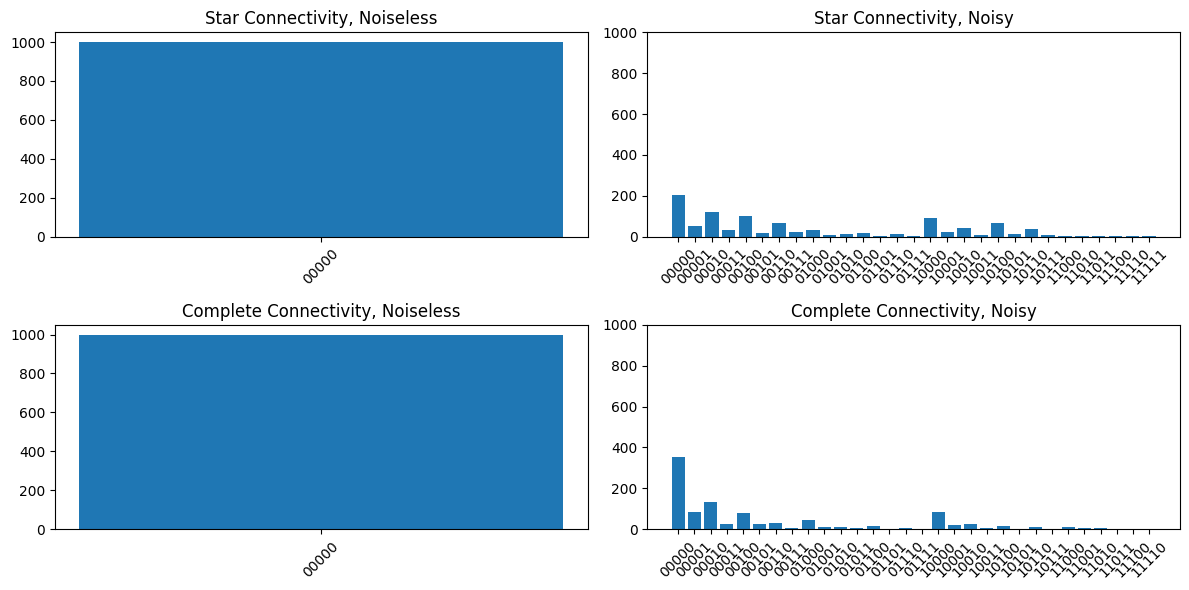

In [44]:
data = [result_star_cz, noisy_result_star_cz, result_complete_cz, noisy_result_complete_cz]
titles = ["Star Connectivity, Noiseless", "Star Connectivity, Noisy", "Complete Connectivity, Noiseless", "Complete Connectivity, Noisy"]
plot_histograms(data, titles, lim=True)

In [45]:
# Noisy/Noiseless results for random CZ circuit on line connectivity
noisy_result_line_cz = layout_noise_test(conn_line, random_cz_circ, is_noisy=True)
result_line_cz = layout_noise_test(conn_line, random_cz_circ, is_noisy=False)

# Noisy/Noiseless results for random CZ circuit on complete connectivity
noisy_result_complete_cz = layout_noise_test(conn_complete, random_cz_circ, is_noisy=True)
result_complete_cz = layout_noise_test(conn_complete, random_cz_circ, is_noisy=False)

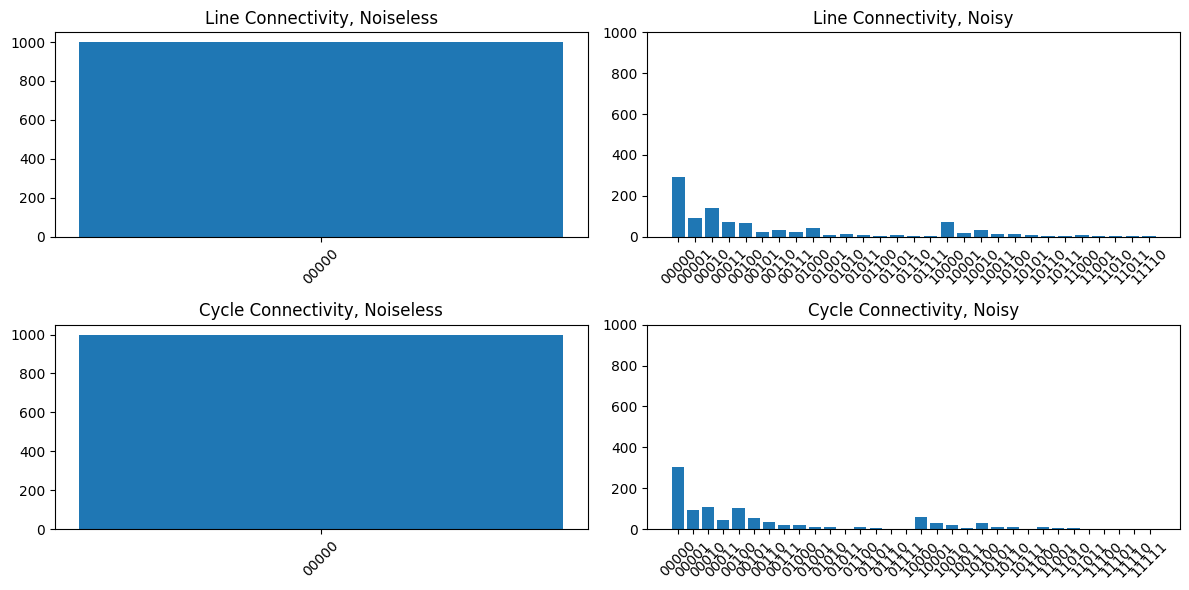

In [46]:
data = [result_line_cz, noisy_result_line_cz, result_cycle_cz, noisy_result_cycle_cz]
titles = ["Line Connectivity, Noiseless", "Line Connectivity, Noisy", "Cycle Connectivity, Noiseless", "Cycle Connectivity, Noisy"]
plot_histograms(data, titles, lim=True)

In [50]:
er_star = noisy_result_star_cz['00000'] / 1000
er_cycle = noisy_result_cycle_cz['00000'] / 1000
er_line = noisy_result_line_cz['00000'] / 1000
er_complete = noisy_result_complete_cz['00000'] / 1000

print("Noisy simulation results")
print(f"Error rate for star connectivity: {1 - er_star}")
print(f"Error rate for cycle connectivity: {1 - er_cycle}")
print(f"Error rate for line connectivity: {1 - er_line}")
print(f"Error rate for complete connectivity: {1 - er_complete}")


Noisy simulation results
Error rate for star connectivity: 0.798
Error rate for cycle connectivity: 0.694
Error rate for line connectivity: 0.71
Error rate for complete connectivity: 0.613


### Simulation - QFT(5)

In [17]:
# Noisy/Noiseless results for QFT circuit on star connectivity
noisy_result_star_qft = layout_noise_test(conn_star, qft_circ, is_noisy=True)
result_star_qft = layout_noise_test(conn_star, qft_circ, is_noisy=False)

# Noisy/Noiseless results for QFT circuit on complete connectivity
noisy_result_complete_qft = layout_noise_test(conn_complete, qft_circ, is_noisy=True)
result_complete_qft = layout_noise_test(conn_complete, qft_circ, is_noisy=False)

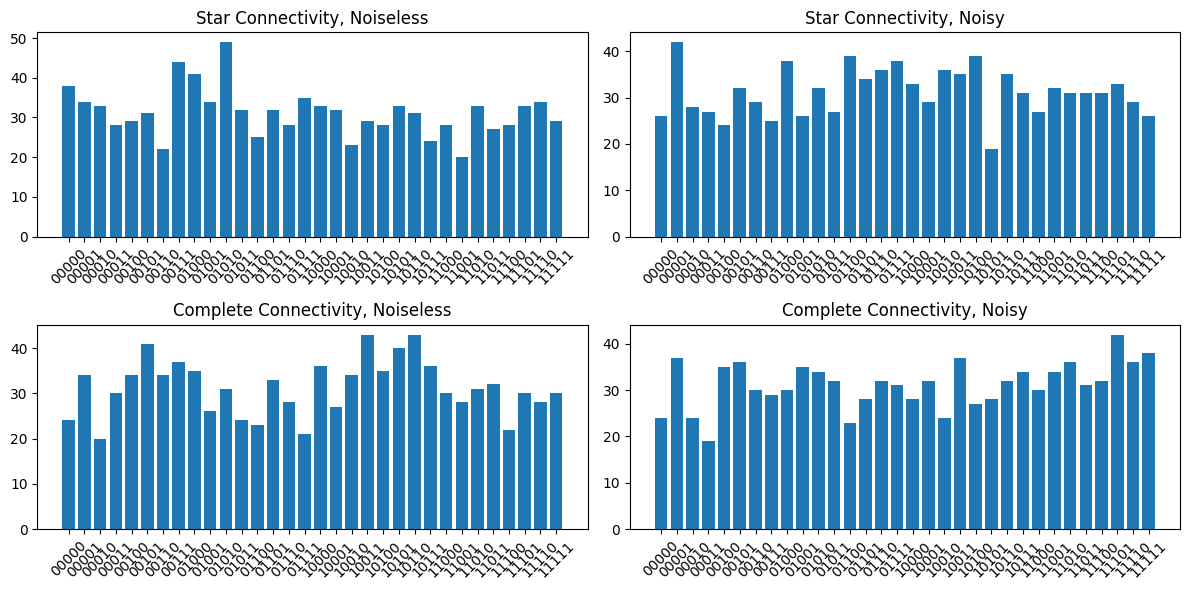

In [31]:
data = [result_star_qft, noisy_result_star_qft, result_complete_qft, noisy_result_complete_qft]
titles = ["Star Connectivity, Noiseless", "Star Connectivity, Noisy", "Complete Connectivity, Noiseless", "Complete Connectivity, Noisy"]
plot_histograms(data, titles)  

- Cannot tell the error rate because of the complexity of the QFT circuit